In [1]:
import cupy as cp
from cupyx import scatter_add
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from includes.preprocessor import write_keywords,write_birth,write_parameters
from includes.gamma import domain_mgr, heat_solve_mgr,load_toolpath,get_toolpath
%matplotlib notebook
cp.cuda.Device(0).use()
!nvidia-smi
import pyvista as pv
from pyvirtualdisplay import Display
import vtk

Sun May  9 17:25:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:01:00.0 Off |                  Off |
| 35%   48C    P8    28W / 260W |   3138MiB / 48598MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:21:00.0 Off |                  Off |
| 52%   

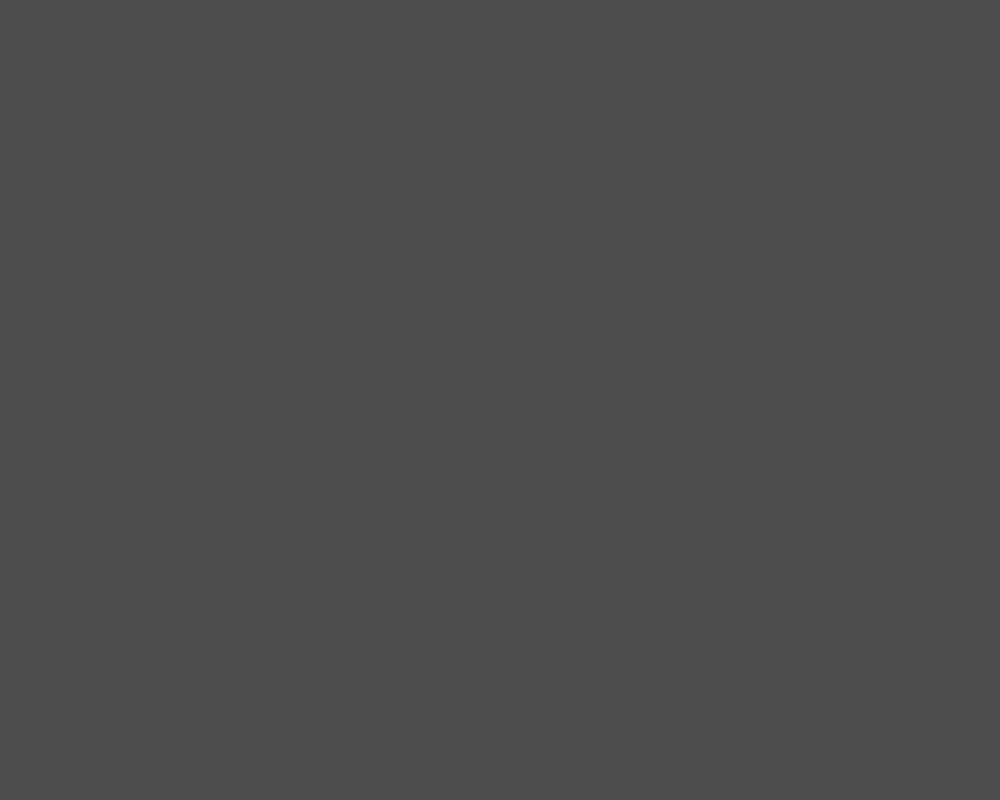

In [3]:
file_name = 'input_files/thinwall.inp'
output_file = 'input_files/thinwall.k'
toolpath_file = 'input_files/thinwall_toolpath.crs'
height = 20
radius = 1
path_resolution = 0.1
write_keywords(file_name,output_file,height)
write_birth(output_file,toolpath_file,path_resolution,radius,gif_end=100,nFrame=100)
write_parameters(output_file)

In [2]:
def save_vtk(filename):
    active_elements = domain.elements[domain.active_elements].tolist()
    active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
    active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
    points = domain.nodes.get()
    active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
    active_grid.point_arrays['temp'] = heat_solver.temperature.get()
    active_grid.save(filename)

In [3]:
domain = domain_mgr(filename='input_files/cylinder.k',toolpath_file='input_files/cylinder_toolpath.crs')

Time of reading input files: 1.7585227489471436
Time of calculating critical timestep: 0.35007476806640625
Time of reading and interpolating toolpath: 0.13937830924987793
Number of nodes: 122825
Number of elements: 98176
Number of time-steps: 177147
Time of generating surface: 325.69619631767273


In [4]:
domain.dt

0.004730555782438592

In [ ]:
%%time
Ki = 20
Kp = 120
Kd = 0

heat_solver = heat_solve_mgr(domain)
melt_data = []
domain.current_time = 0
endtime = 838
timestep = int(endtime/domain.dt)+1
angle = np.arctan2(domain.nodes[:,1],domain.nodes[:,0])
distance = np.sqrt(domain.nodes[:,1]**2+domain.nodes[:,0]**2)
ind = []
for A in [np.pi/4,np.pi/2,np.pi*3/4,-np.pi/4,-np.pi/2,-np.pi*3/4]:
    a = np.where((abs(angle-A)<7e-3)*(abs(distance-30)<0.1)*(domain.nodes[:,2]>0)*(domain.nodes[:,2]<20))
    ind = np.append(ind,a[0])
ind = ind.astype(dtype=np.int32)
temp_data = []

heat_solver.q_in = 200
control_step = 15
control_track = 0
delay_step = 4
delay_track = 0
melt_depth_control = 0
err_n = 0
err_n_1 = 0
err_n_2 = 0
control_data = []
file_num = 0

for t in range(1,timestep):
    melt_depth_desired = 2.0
    heat_solver.time_integration()
    heat_solver.calculate_melt()
    if t % 5000 == 0:
        mempool = cp.get_default_memory_pool()
        mempool.free_all_blocks()
        print("Current time:  {}, Percentage done:  {}%".format(domain.current_time,100*t/timestep))
    
    if t % 1000 == 0:
        filename = 'cylinder_half/cylinder_{}.vtk'.format(file_num)
        save_vtk(filename)
        file_num = file_num + 1
    
    temp_data.append(np.array(heat_solver.temperature[ind].get()))
    melt_data.append([domain.current_time,heat_solver.melt_depth,heat_solver.q_in,heat_solver.laser_state])
    
    if domain.current_time>57:
        if heat_solver.laser_state>0:
            control_track += 1
            melt_depth_control += heat_solver.melt_depth/control_step
            if control_track == control_step:
                if delay_track == delay_step:
                    control_track = 0
                    if heat_solver.laser_loc[1]>0:
                        melt_depth_desired = 1.4
                    err_n = melt_depth_desired - melt_depth_control 
                    heat_solver.q_in = heat_solver.q_in + Kp * (err_n - err_n_1) + Ki * err_n + Kd * (err_n + err_n_2 - 2*err_n_1)
                    heat_solver.q_in = cp.clip(heat_solver.q_in,100,400)
                    err_n_2 = err_n_1
                    err_n_1 = err_n
                    melt_depth_control = 0
                else:
                    control_track = 0
                    melt_depth_control = 0
                    delay_track+=1

        if heat_solver.laser_state==0:
            control_track = 0
            delay_track = 0
            err_n = 0
            err_n_1 = 0
            err_n_2 = 0

melt_data=np.array(melt_data)
np.save('cylinder_half/melt.npy',melt_data)
np.save('cylinder_half/temp.npy',temp_data)

Current time:  23.65277891219141, Percentage done:  2.822514634738381%


In [ ]:
%%time
Ki_list = np.array([0, 0, 0,  0,  0,  0,10,20,30,40,60, 10, 20, 30, 40, 60, 10, 20, 30, 40, 60])
Kp_list = np.array([0,20,80,120,200,400,80,80,80,80,80,120,120,120,120,120,200,200,200,200,200])
Kd = 0
for i in range (0,21):
    Ki = Ki_list[i]
    Kp = Kp_list[i]
    heat_solver = heat_solve_mgr(domain)
    melt_data = []
    domain.current_time = 0
    endtime = 96
    timestep = int(endtime/domain.dt)+1

    temp_data = []

    heat_solver.q_in = 200
    control_step = 15
    control_track = 0
    delay_step = 4
    delay_track = 0 
    melt_depth_control = 0
    err_n = 0
    err_n_1 = 0
    err_n_2 = 0
    control_data = []
    file_num = 0

    for t in range(1,timestep):
        melt_depth_desired = 1.4
        heat_solver.time_integration()
        heat_solver.calculate_melt()
        if t % 5000 == 0:
            mempool = cp.get_default_memory_pool()
            mempool.free_all_blocks()
            print("Current time:  {}, Percentage done:  {}%".format(domain.current_time,100*t/timestep))

        melt_data.append([domain.current_time,heat_solver.melt_depth,heat_solver.q_in,heat_solver.laser_state])
        control_data.append([control_track,err_n,err_n_1,melt_depth_control])
        if domain.current_time>25:
            if heat_solver.laser_state>0:
                control_track += 1
                melt_depth_control += heat_solver.melt_depth/control_step
                if control_track == control_step:
                    if delay_track == delay_step:
                        control_track = 0
                        err_n = melt_depth_desired - melt_depth_control 
                        heat_solver.q_in = heat_solver.q_in + Kp * (err_n - err_n_1) + Ki * err_n + Kd * (err_n + err_n_2 - 2*err_n_1)
                        heat_solver.q_in = cp.clip(heat_solver.q_in,100,500)
                        err_n_2 = err_n_1
                        err_n_1 = err_n
                        melt_depth_control = 0
                    else: 
                        control_track = 0
                        melt_depth_control = 0
                        delay_track+=1

            if heat_solver.laser_state==0:
                control_track = 0
                delay_track = 0
                err_n = 0
                err_n_1 = 0
                err_n_2 = 0
                heat_solver.q_in = 200

    melt_data=np.array(melt_data)
    control_data = np.array(control_data)
    data1 = np.concatenate((melt_data,control_data),axis=1)
    np.save('thinwall/melt_kp{}ki{}'.format(Kp,Ki),data1)

Current time:  23.938625014765876, Percentage done:  24.935168561739477%
Current time:  47.87725002953873, Percentage done:  49.870337123478954%
Current time:  71.81587504431756, Percentage done:  74.80550568521844%
Current time:  95.7545000590964, Percentage done:  99.74067424695791%
Current time:  23.938625014765876, Percentage done:  24.935168561739477%
Current time:  47.87725002953873, Percentage done:  49.870337123478954%
Current time:  71.81587504431756, Percentage done:  74.80550568521844%
Current time:  95.7545000590964, Percentage done:  99.74067424695791%


In [ ]:
display = Display(visible=0)
_ = display.start()
active_elements = domain.elements[domain.active_elements].tolist()
active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
points = domain.nodes.get()
active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
active_grid.point_arrays['temp'] = heat_solver.temperature.get()
p = pv.Plotter(window_size=(2000,1600))
p.camera_position = ((0, -100, 180),(0, 0, 0),(0.0, 0.0, 1.0))
p.add_mesh(active_grid, show_edges=True, scalars='temp',cmap="coolwarm")
p.show()

In [ ]:
plt.plot(melt_data[:,0],melt_data[:,1])
plt.plot(melt_data[:,0],melt_data[:,2]/200)
